<a href="https://colab.research.google.com/github/matand380/DNN_final_project_2024/blob/main/DNN_final_project_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction to Deep Learning - Final Project** 🖥

## Team Information
- **Course:** Introduction to Deep Learning

- **Semester:** Fall 2024

- **Lectrurer:** Dr. Moshe Butman

- **Institution:** The College of Management Academic Studies

- **Team Members:** Eviatar Didon 313205387, Matan Drabkin 201416690

## Project Overview

### Objective

This project centers around the application of deep learning techniques to classify chest X-ray images into distinct categories,

with a specific emphasis on differentiating between healthy cases and those diagnosed with pneumonia.

The dataset for training and evaluation includes a total of 5863 X-ray images, categorized as follows:

- A. **Healthy**
- B. **Pneumonia**
  - Bacterial Pneumonia
  - Viral Pneumonia



## Kaggle Dataset Downloading and Unzipping

### Prerequisites

Ensure that the necessary packages (`kaggle`) are installed before running the code. Use the following command to install the `kaggle` package:

In [46]:
!pip install kaggle

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 572, in _determine_conflicts
    return check_install_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_set_from_installed()
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/operations/check.py", line 42, in create_package_set_from_installed
    dependencies = list(dist.iter_dependencies())


### Uploading Kaggle API Key

Use the file picker to upload your Kaggle API key:


In [47]:
from google.colab import files

uploaded = files.upload()

KeyboardInterrupt: 

### Move API Key to the Right Directory

After uploading the API key, please ensure that Kaggle can use the API key for authentication.

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### Download and Unzip Kaggle Dataset

download the Chest X-ray Pneumonia dataset and unzip it in the Colab environment:

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip

# Preprocessing

## Data augmentation and normalization

In [68]:
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Paths
train_dir = '/content/chest_xray/train'
val_dir = '/content/chest_xray/val'
test_dir = '/content/chest_xray/test'

# ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

## Reorganization of the data

In the original data there's only 16 samples for the validation set. At the first training we got overfitting on the validation so we reorganize the samples in order to get more balanced data

In [69]:


# We load all file paths in the training and validation directories and combine them
all_train_files = []
for root, dirs, files in os.walk(train_dir):
    all_train_files.extend([os.path.join(root, file) for file in files])

all_val_files = []
for root, dirs, files in os.walk(val_dir):
    all_val_files.extend([os.path.join(root, file) for file in files])

all_files = all_train_files + all_val_files

labels = [os.path.basename(os.path.dirname(file)) for file in all_files]

# Split the into training and validation sets
train_files, val_files, train_labels, val_labels = train_test_split(
    all_files, labels, test_size=0.2, random_state=42, stratify=labels
)

# DataGenerators for training and validation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_files, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_files, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

# Test generator for evaluation
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

num_val_images = len(val_files)
print(f"Number of images in the validation set: {num_val_images}")

num_train_images = len(train_files)
print(f"Number of images in the validation set: {num_train_images}")



Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 images belonging to 2 classes.
Number of images in the validation set: 1047
Number of images in the validation set: 4185


#Building the model

we tried setting the lreaning rate to 0.01 but we got worse results than 0.001 (which is the default for Adam optimizer)

In [70]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #used defualt lr = 0.001

model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_13 (Flatten)        (None, 186624)            0         
                                                                 
 dense_27 (Dense)            (None, 128)             

In [66]:
print("Number of training samples:", train_generator.samples)


Number of training samples: 4185


In [61]:
from google.colab import drive

drive.mount('/content/gdrive')

drive_path = '/content/gdrive/My Drive/Colab Notebooks/DNN_final_project_2024'


Mounted at /content/gdrive


In [71]:
# Train the model

from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(f'{drive_path}/best_model.h5', save_best_only=True)

history = model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/10
131/131 [==============================] - ETA: 0s - loss: 0.5831 - accuracy: 0.8002

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


131/131 [==============================] - 102s 754ms/step - loss: 0.5831 - accuracy: 0.8002 - val_loss: 0.1960 - val_accuracy: 0.9303
Epoch 2/10
131/131 [==============================] - 98s 751ms/step - loss: 0.2837 - accuracy: 0.8803 - val_loss: 0.1827 - val_accuracy: 0.9331
Epoch 3/10
131/131 [==============================] - 93s 708ms/step - loss: 0.2655 - accuracy: 0.8961 - val_loss: 0.1827 - val_accuracy: 0.9341
Epoch 4/10
131/131 [==============================] - 98s 746ms/step - loss: 0.2431 - accuracy: 0.9044 - val_loss: 0.1611 - val_accuracy: 0.9398
Epoch 5/10
131/131 [==============================] - 98s 750ms/step - loss: 0.2303 - accuracy: 0.9109 - val_loss: 0.1408 - val_accuracy: 0.9417
Epoch 6/10
131/131 [==============================] - 101s 774ms/step - loss: 0.2395 - accuracy: 0.9104 - val_loss: 0.1391 - val_accuracy: 0.9580
Epoch 7/10
131/131 [==============================] - 101s 772ms/step - loss: 0.2265 - accuracy: 0.9082 - val_loss: 0.1355 - val_accuracy: 

In [72]:
print("Training Accuracy:", round(history.history['accuracy'][-1], 3))
print("Training Loss:", round(history.history['loss'][-1], 3))
print("Validation Accuracy:", round(history.history['val_accuracy'][-1], 3))
print("Validation Loss:", round(history.history['val_loss'][-1], 3))

Training Accuracy: 0.922
Training Loss: 0.196
Validation Accuracy: 0.956
Validation Loss: 0.106


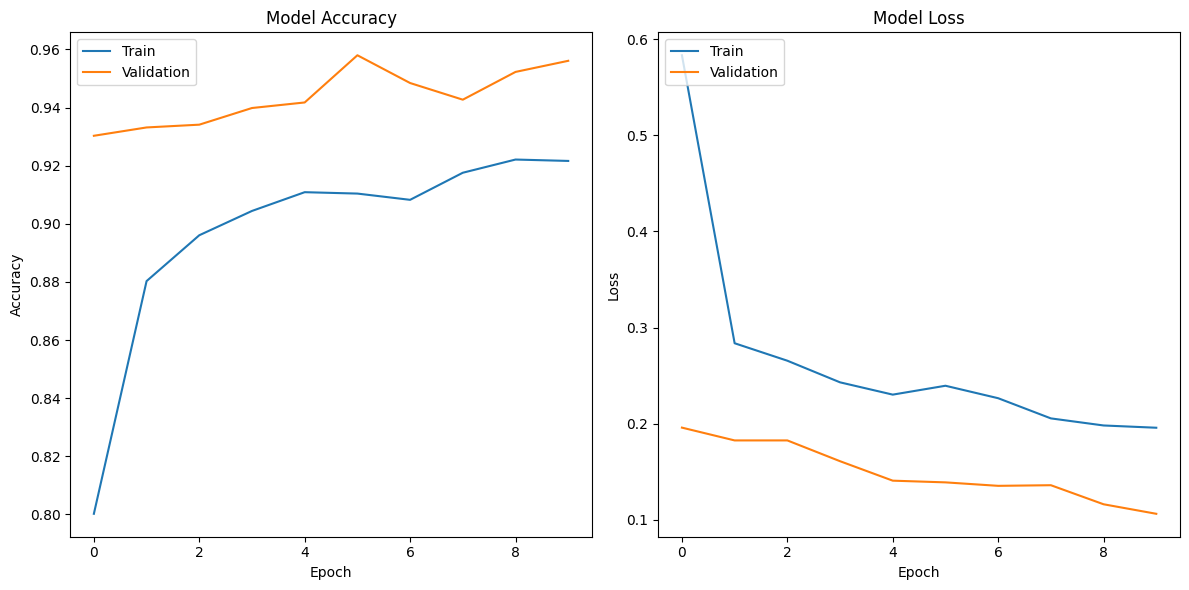

In [73]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()
